# 获取原始数据

In [1]:
import os
import sys
import talib as ta
syspath = os.path.split(os.path.abspath("."))[0]
sys.path.append(syspath)
import univ3api.simulation as sim
import univ3api.utils as utils
import importlib
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pickle
import talib as ta
from dateutil.parser import parse
import numpy as np
# run if simulation file is updated
importlib.reload(sim)

HOST = "mongodb://172.16.11.81:27017/ETHDATA"
source = sim.DataUtilMongoDB(HOST)

from datetime import datetime
import time
d1 = datetime(2021,5,10, 9)
d2 = datetime(2021,11,10,9)
t1 = int(time.mktime(d1.timetuple()))
t2 = int(time.mktime(d2.timetuple()))

# print(d1.timetuple())
# print(time.mktime(d1.timetuple()))
# print(int(time.mktime(d1.timetuple())))

# swapdata = source.swap_by_time("SWAP_WETH_USDT_3000", t1, t2)
swapdata = source.swap_by_time("SWAP_USDC_WETH_3000", t1, t2)
swapdata.tail()
pricedata = swapdata[["timestamp", "sqrtPriceX96"]]
# pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(18, 6).x96_to_price)
pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(6, 18).x96_to_price)
pricedata['datetime']  = pd.to_datetime(pricedata['timestamp'],unit='s')
pricedata['datetime'] = [str(tmp)[:] for tmp in pricedata['datetime'].tolist()]
pricedata.head(30)

,timestamp,sqrtPriceX96,price,datetime
0,1620609472,1267554519342589161168659854845874,0.000256,2021-05-10 01:17:52
1,1620609830,1267498129839936824485169221023868,0.000256,2021-05-10 01:23:50
2,1620609889,1267496927736336268048970777338285,0.000256,2021-05-10 01:24:49
3,1620609889,1267496466129159558106023913391909,0.000256,2021-05-10 01:24:49
4,1620609894,1267269382521328460205280017540103,0.000256,2021-05-10 01:24:54
5,1620610623,1267754285381064572722609533899482,0.000256,2021-05-10 01:37:03
6,1620611235,1267754213073572770799115829561393,0.000256,2021-05-10 01:47:15
7,1620611299,1267275517316596160636534532129961,0.000256,2021-05-10 01:48:19
8,1620611299,1266795557299383075398246972590894,0.000256,2021-05-10 01:48:19
9,1620611394,1266581294445699141380240121831618,0.000256,2021-05-10 01:49:54


In [2]:
pricedata['SmaLowerLma'] = [np.nan]*len(pricedata)
pricedata['VolLowerBelowmaQuantile50'] = [np.nan]*len(pricedata)
pricedata['CloseLowerMA'] = [np.nan]*len(pricedata)
pricedata['VolHigherOvermaQuantile50Twosigma'] = [np.nan]*len(pricedata)
pricedata['revoke_pos'] = [np.nan]*len(pricedata)

# 指标计算

In [3]:
pricedata_res = pricedata[['timestamp','sqrtPriceX96','price',
                           'SmaLowerLma',
                           'VolLowerBelowmaQuantile50',
                          'CloseLowerMA',
                           'VolHigherOvermaQuantile50Twosigma',
                           'revoke_pos']]
pricedata_res

,timestamp,sqrtPriceX96,price,SmaLowerLma,VolLowerBelowmaQuantile50,CloseLowerMA,VolHigherOvermaQuantile50Twosigma,revoke_pos
0,1620609472,1267554519342589161168659854845874,0.000256,NaN,NaN,NaN,NaN,NaN
1,1620609830,1267498129839936824485169221023868,0.000256,NaN,NaN,NaN,NaN,NaN
2,1620609889,1267496927736336268048970777338285,0.000256,NaN,NaN,NaN,NaN,NaN
3,1620609889,1267496466129159558106023913391909,0.000256,NaN,NaN,NaN,NaN,NaN
4,1620609894,1267269382521328460205280017540103,0.000256,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
153322,1636505287,1151304179731807924804200863381341,0.000211,NaN,NaN,NaN,NaN,NaN
153323,1636505306,1153213095406308275655367738380110,0.000212,NaN,NaN,NaN,NaN,NaN
153324,1636505306,1153226560737155904671591020768514,0.000212,NaN,NaN,NaN,NaN,NaN
153325,1636505306,1153227466349991390439811165863993,0.000212,NaN,NaN,NaN,NaN,NaN


# 回测

In [4]:
init_price = pricedata_res["price"][0]

decimal0 = 6 #USDC的精度
decimal1 = 18 #ETH的精度

init_amount0 = 1000000*1e6 #初始持有USDC的数量
init_amount1 = 0 #初始持有ETH的数量
print('init_price =',init_price)

init_price = 0.0002559611947100053


# 建池撤池详细信息

In [5]:
import Strategy_none_3000_50per
importlib.reload(utils)
importlib.reload(sim)
importlib.reload(Strategy_none_3000_50per)
strategy = Strategy_none_3000_50per.HoldStrategy(init_amount0, init_amount1, decimal0, decimal1, sim.PoolFee.low, True)
strategy.init(swapdata.iloc[0].to_dict())

# strategy.run(swapdata, priceDt)
strategy.run(swapdata, pricedata_res)

report = strategy.report()

**********************【Price Below MA】【创建Short Vol池子】【第1次建池】***********************************
转换后钱包中余额 amount0:  349675000000.0 amount1:  166169275899699363840
price:  0.0002559611947100053
$$$$$$$【Upper Price】: 0.00038394179206500793
$$$$$$$【Lower Price】: 0.00012798059735500265
######【L】:30690405793635532【USDC】:349675000000【ETH】:144215143323547123712
将要投入池子的数量 amount_t0: 349675000000 amount_t1: 144215143323547058176
【RealWorldTime】:2021-05-10 09:17:52, Timestamp: 1620609472, Blocknumber: 12403600
Mint position： Position(L=30690174960131528, tick=[186660, 197640], range=[2612.3599, 7831.8525])
【Mint amount】: token0=349668.132233, token1=144.21514332354707
Wallet amount: token0=6.867767, token1=21.954132576152304


# 获取原始绩效

In [6]:
positions = report.positions
positions

{1: <univ3api.simulation.PositionReport at 0x25d385c22b0>}

In [7]:
total_balance = report.total_balance(draw_plot=False, plain=True)
backtest_report = total_balance.copy(deep=True)

In [8]:
price = pricedata.drop_duplicates("timestamp").set_index("timestamp")["price"]
price
usdc_balance = total_balance.set_index("timestamp")[["amount0NoFee", "cumFee0"]].sum(axis=1)
eth_balance = total_balance.set_index("timestamp")[["amount1NoFee", "cumFee1"]].sum(axis=1) / price
eth_balance+usdc_balance
# eth_balance.plot()
# usdt_balance.plot()
tb_Timing = (eth_balance+usdc_balance)
tb_Timing_origin = tb_Timing.copy(deep=True)
time_to_print = list(map(time.localtime,tb_Timing.index.tolist()))
time_to_print_2  = [time.strftime('%Y-%m-%d %H:%M:%S', i) for i in time_to_print]
# time_to_print_2  = [time.strftime('%Y-%m-%d', i) for i in time_to_print]
tb_Timing.index = time_to_print_2
tb_Timing.plot(rot = 45,grid=True)
# tb_Timing.to_csv('../../data/usdceth/tb_timing_v2.csv')
# tb_Timing_origin.to_csv('../../data/usdceth/tb_timing_origin_v2.csv')

<AxesSubplot:>

In [9]:
eth_balance
eth_balance_df = pd.DataFrame(eth_balance)
eth_balance_df.columns = ['eth_balance']
eth_balance_df

,eth_balance
timestamp,
1620609472,649197.141340
1620609830,649169.560782
1620609889,649168.274095
1620609894,649057.601914
1620610623,649295.155166
...,...
1636505114,589886.326232
1636505262,589934.287716
1636505287,589936.414631


In [10]:
usdc_balance
usdc_balance_df = pd.DataFrame(usdc_balance)
usdc_balance_df.columns = ['usdc_balance']
usdc_balance_df

,usdc_balance
timestamp,
1620609472,349675.000000
1620609830,349760.384753
1620609889,349762.904052
1620609894,350106.830937
1620610623,349372.943144
...,...
1636505084,555529.046708
1636505114,554800.434744
1636505262,554691.895612


In [11]:
tb_Timing

2021-05-10 09:17:52    9.988721e+05
2021-05-10 09:23:50    9.989299e+05
2021-05-10 09:24:49    9.989312e+05
2021-05-10 09:24:54    9.991644e+05
2021-05-10 09:37:03    9.986681e+05
                           ...     
2021-11-10 08:45:14    1.144687e+06
2021-11-10 08:47:42    1.144626e+06
2021-11-10 08:48:07    1.144623e+06
2021-11-10 08:48:26    1.142668e+06
2021-11-10 08:48:53             NaN
Length: 118264, dtype: float64

# 计算绩效指标

In [12]:
# tb_Timing.resample('D').sum()
pd.to_datetime(tb_Timing.index.tolist()[0])
tb_Timing.index = pd.to_datetime(tb_Timing.index)
tb_Timing.resample('D').last()

2021-05-10    1.038966e+06
2021-05-11    1.014740e+06
2021-05-12    1.046499e+06
2021-05-13    9.721822e+05
2021-05-14    1.037580e+06
                  ...     
2021-11-06    1.099461e+06
2021-11-07    1.126696e+06
2021-11-08    1.147266e+06
2021-11-09    1.151917e+06
2021-11-10    1.142668e+06
Freq: D, Length: 185, dtype: float64

In [13]:
df_tb = pd.DataFrame(tb_Timing.resample('D').last(),columns=['close'])
df_tb['return'] = df_tb['close'].pct_change()
df_tb['return_2'] = df_tb['close']/df_tb['close'].shift(1) - 1
df_tb = df_tb.iloc[:-1,:]
df_tb

,close,return,return_2
2021-05-10,1.038966e+06,NaN,NaN
2021-05-11,1.014740e+06,-0.023317,-0.023317
2021-05-12,1.046499e+06,0.031297,0.031297
2021-05-13,9.721822e+05,-0.071015,-0.071015
2021-05-14,1.037580e+06,0.067270,0.067270
...,...,...,...
2021-11-05,1.109617e+06,-0.002971,-0.002971
2021-11-06,1.099461e+06,-0.009153,-0.009153
2021-11-07,1.126696e+06,0.024771,0.024771
2021-11-08,1.147266e+06,0.018257,0.018257


<AxesSubplot:>

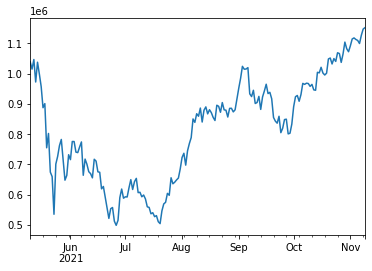

In [14]:
df_tb['close'].plot()

In [15]:
from scipy.stats.mstats import gmean
import math
def max_drawdown(df):
    """
    :return: Max drawdown of the financial series.
    """
    roll_max = df['close'].expanding().max()
    maxDrawdown = -1 * np.min(df['close'] / roll_max - 1)  # 计算得到最大回撤
    return maxDrawdown

def annual_return(df):
    """
    :return: Annual return.
    """
    annualReturn = gmean(df['return'].dropna() + 1) ** 365 - 1  # 得到年化收益率
    return annualReturn

def annual_std(df):
    """
    :return: The annual standard deviation.
    """
    dailyStd = df['return'].std()  # 得到日度波动率
    annualStd = dailyStd * math.sqrt(365)  # 得到年化波动率
    return annualStd

def sharpe_ratio(df):
    """
    :return:  Sharpe ratio.
    """
    annualReturn = annual_return(df)
    annualStd = annual_std(df)
    sharpeRatio = annualReturn / annualStd  # 得到夏普比
    return sharpeRatio

def calmar_ratio(df):
    """
    :return: Calmar ratio.
    """
    annualReturn = annual_return(df)
    maxDrawdown = max_drawdown(df)
    calmarRatio = annualReturn / maxDrawdown
    return calmarRatio

def max_drawdown_duration(df):
    """
    :return: Max Drawdown duration
    """
    xdate = df_tb.index.tolist()
    ycapital = df_tb['close'].tolist()
    duration = []
    tmp_max_capital = ycapital[0]
    for c in ycapital:
        if c >= tmp_max_capital:
            duration.append(0)
        else:
            duration.append(duration[-1]+1)
        tmp_max_capital = max(c, tmp_max_capital)
    MaxDDD = max(duration)
    endidx = np.argmax(duration)
    startidx = endidx - MaxDDD
#     print(xdate[startidx])
#     print(xdate[endidx])
    startD = xdate[startidx]
    endD = xdate[endidx]
#     return MaxDDD, startidx, endidx
    return MaxDDD, startD,endD
    


【SWAP_USDC_WETH_3000】

USDC手续费 8347.776387 ETH手续费(USDC计价) 11798.510964862175
***************************资金曲线绩效***************************
最大回撤 0.5237884989582626
最长回撤持续期 160 日 起始日期 2021-05-12 00:00:00 结束日期 2021-10-19 00:00:00
年化收益 0.22855581332998387
夏普比率 0.23075396155883696
卡尔玛比率 0.43635133987200436


<AxesSubplot:title={'center':'Total Balance'}>

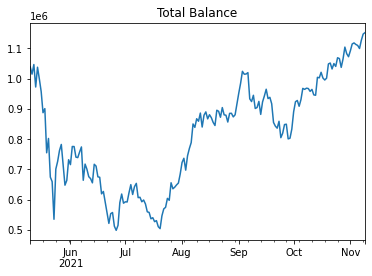

In [16]:
print('【SWAP_USDC_WETH_3000】')
print()

cumfee0 = backtest_report['cumFee0'].tolist()[-1]
cumfee1 = backtest_report['cumFee1'].tolist()[-1]/pricedata_res['price'].tolist()[-1]
print('USDC手续费',cumfee0,'ETH手续费(USDC计价)',cumfee1)
print('***************************资金曲线绩效***************************')
print('最大回撤',max_drawdown(df_tb))
print('最长回撤持续期',max_drawdown_duration(df_tb)[0],'日',
      '起始日期',max_drawdown_duration(df_tb)[1],
      '结束日期',max_drawdown_duration(df_tb)[2])
print('年化收益',annual_return(df_tb))
print('夏普比率',sharpe_ratio(df_tb))
print('卡尔玛比率',calmar_ratio(df_tb))
df_tb['close'].plot(title='Total Balance')